# Exploring 311 dataset for department resource utilization

In [1]:
# Importing all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import random
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
plt.style.use(['fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 3

## Pre-processing 

As part of pre-processing, we've followed the following techniques:
1) Data Sampling 
2) Data Cleaning
3) Data Integration
4) Data Reduction
5) Feature Engineering

### Data Sampling

Because of the huge size of the dataset, we've used random sampling to create a smaller dataset containing similar distributions 
as in our primary dataset. We've created a method **GenerateDataSample()** to generate a smaller dataset and store it as '311_sampled_data.csv'

In [2]:
def GenerateDataSample():
    # Importing the necessary libraries
    import pandas as pd
    import random

    # Specifying the CSV file path
    csv_file = '311_Service_Requests.csv'

    # Read a random sample of 1% of the data into the dataframe
    df = pd.read_csv(csv_file, skiprows=lambda i: i > 0 and random.random() > 0.01)

    # Creating the random data sample dataset
    df.to_csv('311_sampled_data.csv', index=False)

    return df

In [3]:
# Calling the function to generate the sample dataset
df = GenerateDataSample()
df.head()

C:\Users\sumed\AppData\Local\Temp\ipykernel_17376\2321768201.py:10: DtypeWarning: Columns (8,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, skiprows=lambda i: i > 0 and random.random() > 0.01)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,18541168,08/23/2010 12:00:00 AM,09/03/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,NONCONST,VERMIN,RESIDENTIAL BUILDING,10003,7 ST MARKS PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.729304,-73.989302,"(40.729304425994854, -73.98930216741698)"
1,18541175,08/23/2010 12:00:00 AM,09/07/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,PAINT - PLASTER,CEILING,RESIDENTIAL BUILDING,10460,1528 BRYANT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.833538,-73.886855,"(40.83353835504742, -73.88685532023764)"
2,18541260,08/23/2010 12:00:00 AM,09/10/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,APPLIANCE,ELECTRIC/GAS-RANGE,RESIDENTIAL BUILDING,10035,1993 LEXINGTON AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.802164,-73.939022,"(40.802164418613806, -73.93902242696387)"
3,18541820,08/23/2010 01:46:00 PM,08/26/2010 12:00:00 PM,DSNY,Department of Sanitation,Dirty Conditions,E2 Receptacle Violation,Sidewalk,10001,466 WEST 26 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.749133,-74.001714,"(40.74913299763879, -74.00171432814095)"
4,18541870,08/23/2010 12:00:00 AM,09/04/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,GENERAL CONSTRUCTION,FLOOR,RESIDENTIAL BUILDING,10453,2183 GRAND CONCOURSE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.855380,-73.901260,"(40.85538025336124, -73.90125960889755)"


### Data Cleaning

The sample data also contains lot of inconsistent and null value data, and needs to be transformed accordingly by either filling with appropriate values / deleting the rows and more. In this section, we clean the 311 dataset and the zip code dataset, which would be later used for analysis and modelling. We've created different methods to execute the tasks, out of which **Clean311Dataset()** and **CleanZipCodeDataset()** are the primary methods for cleaning our datasets.
The two datasets used are
1) 311 sampled dataset
2) Zip code dataset

In [4]:
import pandas as pd
def DoCleaning():
    # Cleaning the 311 dataset
    df311 = Clean311Dataset()
    # Cleaning the zipcode dataset
    dfZip = CleanZipCodeDataset()

    return df311, dfZip

def Clean311Dataset():
    """ To clean the 311 dataset """
    # Using the existing the dataset from the variable if provided
    df = pd.read_csv('311_sampled_data.csv')
    
    # To delete all the columns with majority NaN values
    df = DeleteNaNColumns(df)

    # To filter the rows which do not have any close date
    df = df[df['Closed Date'].notna()]

    # The descriptor contains values like Partial Access, Window Frame, Door, Other/Unknown 
    # We impute the Descriptor values => Other/Unknown for the ones where they are NaN.
    df['Descriptor'] = df['Descriptor'].fillna('Other/Unknown') 

    # We fill the NaN Landmark values as 'Unspecified'
    df['Landmark'] = df['Landmark'].fillna('Unspecified')
    
    # Populating the value for NaN records as 'Address Unknown' because it is already
    # present as an existing label in the column.
    df['Location Type'] = df['Location Type'].fillna('Address Unknown')  

    # For NaN city values, we populate it with Boroughs
    df['City'] = df.City.fillna(df['Borough'])

    # Removing NaN boroughs    
    df = df[df['Borough'].notna()]

    # Removing NaN city values
    df = df[df['City'].notna()]

    # Removing NaN incident addresses
    df = df[df['Incident Address'].notna()]

    # Removing NaN street names
    df = df[df['Street Name'].notna()]
    
    # To remove the nan address types from the dataset.
    df = df[df['Address Type'].notna()]
    
    # Filtering the rows with NaN values for 'Incident Zip' column.
    # We filter this because, this column will be used later for joining with other tables
    df = df[df['Incident Zip'].notna()]

    # Filtering the rows with NaN values for 'Latitude' and 'Longitude' columns.
    # These records are being filtered as to identify the locations for the complaints
    df = df[df['Latitude'].notna()]

    # To filter NaN BBL values from the dataset
    df = df[df['BBL'].notna()]

    # To filter out the rows based on departments.
    df = FilterDepartments(df)

    #df.to_csv('311_clean_data_1.csv',index=False)
    return df

def DeleteNaNColumns(df):
    """ To delete all the columns which have majority (more than 90%) of NaN values """
    nan_columns_to_be_deleted = []
    for col in df.columns:
        isna_count = df[col].isna().sum()
        notna_count = df[col].notna().sum()
        if (notna_count <= 0.1 * (len(df))):
            nan_columns_to_be_deleted.append(col)
    print ("The columns with 90% NaN values in our dataset (would be removed) :")
    print (nan_columns_to_be_deleted)
    df = df.drop(columns = nan_columns_to_be_deleted)
    return df

def isNaColumns(df):
    """ To provide summary of na and non-na values for all the columns """
    for col in df_sample.columns:
        isna_count = df_sample[col].isna().sum()
        notna_count = df_sample[col].notna().sum()
        print (col + " => IsNA : " + str(isna_count) + " Not NA : " + str(notna_count))

def FilterDepartments(df):
    """ To filter the departments in the dataset """
    PlotParetoChart(df)
    # Based on Pareto's principal, we found that 80% of the data is represented by the
    # top 5 departments. 
    # So, we would be filtering our departments.
    # Note: But in our study, we observed that filtering out the rows per department 
    # are creating an issue of loss in some features, and for that reason we filter out at a later stage.
    df_temp = df['Agency'].value_counts()
    return df

def PlotParetoChart(df):
    """ Plotting the Pareto chart for the complaint department wise """
    # Retrieving the frequency of complaints department-wise
    df_new = df['Agency'].value_counts()
    
    # Calculating the cumulative sum of the complaints department-wise
    departments = ( df_new.cumsum() / df_new.sum() ) * 100

    # Plotting the figures
    print ("Here is the Pareto's chart")
    fig, ax = plt.subplots()
    ax.barh(df_new.index, df_new.values, color="C0")
    ax.set_xlabel("Complaint frequency")
    ax.set_ylabel("Departments")
    ax2 = ax.twiny()
    ax2.plot(departments, df_new.index, color="C1", marker="D", ms=7)
    ax2.set_xlim([0, 100])
    ax2.set_xlabel('Cumulative percentage')
    
    plt.show()

def CleanZipCodeDataset():
    """ To clean the zip code dataset """
    import geopandas as gpd
    gdf = gpd.read_file('ZIP_CODE_040114.shp')

    # Excluding the records with 0 population
    gdf = gdf[gdf['POPULATION'] > 0.0]

    # Excluding the records with area <= 0 
    gdf = gdf[gdf['AREA'] > 0.0 ]

    print (gdf.head(10))
    #gdf.to_csv('zip_code_dataset.csv', index=False)
    return gdf
    # Note: Other columns are irrelevant and would not be cleaned as part of the cleaning phase.
    # Those columns would be removed from the dataset in the reduction phase. 


C:\Users\sumed\AppData\Local\Temp\ipykernel_17376\138281614.py:13: DtypeWarning: Columns (8,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('311_sampled_data.csv')


The columns with 90% NaN values in our dataset (would be removed) :
['Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment']
Here is the Pareto's chart


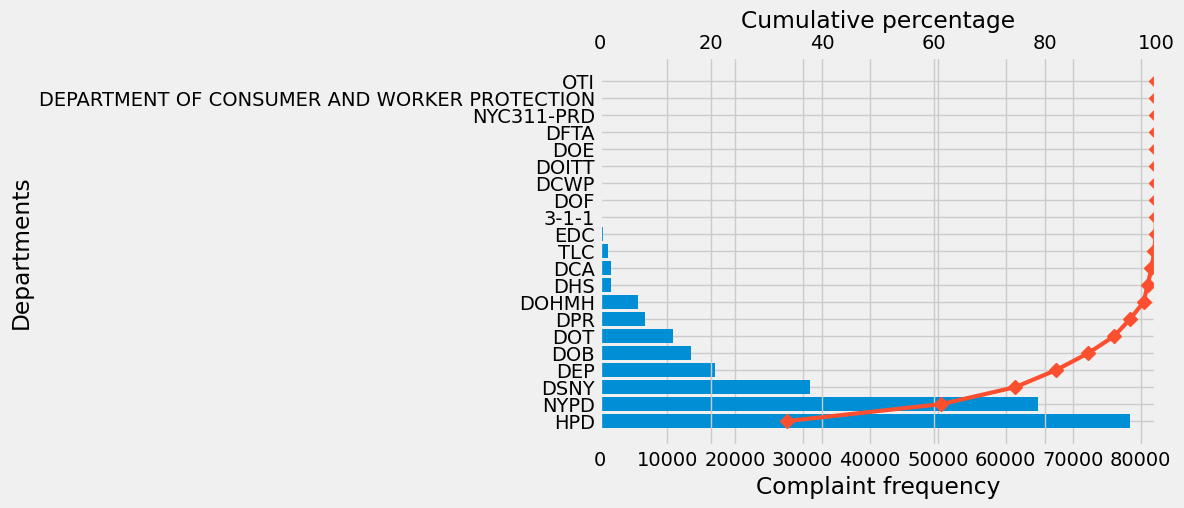

  ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   
5   11226       0  Brooklyn    106132.0  3.940860e+07    NY   Kings      36   
6   11219       0  Brooklyn     92561.0  4.200274e+07    NY   Kings      36   
7   11210       0  Brooklyn     67067.0  4.788702e+07    NY   Kings      36   
8   11230       0  Brooklyn     80857.0  4.992670e+07    NY   Kings      36   
9   11204       0  Brooklyn     77354.0  4.355518e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  

In [5]:
df311, dfZip = DoCleaning()

In [6]:
df311

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location
0,18541168,08/23/2010 12:00:00 AM,09/03/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,NONCONST,VERMIN,RESIDENTIAL BUILDING,10003,7 ST MARKS PLACE,...,1.004640e+09,Unspecified,987215.0,204982.0,UNKNOWN,Unspecified,Unspecified,40.729304,-73.989302,"(40.729304425994854, -73.98930216741698)"
1,18541175,08/23/2010 12:00:00 AM,09/07/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,PAINT - PLASTER,CEILING,RESIDENTIAL BUILDING,10460,1528 BRYANT AVENUE,...,2.030010e+09,Unspecified,1015560.0,242978.0,UNKNOWN,Unspecified,Unspecified,40.833538,-73.886855,"(40.83353835504742, -73.88685532023764)"
2,18541260,08/23/2010 12:00:00 AM,09/10/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,APPLIANCE,ELECTRIC/GAS-RANGE,RESIDENTIAL BUILDING,10035,1993 LEXINGTON AVENUE,...,1.017700e+09,Unspecified,1001132.0,231533.0,UNKNOWN,Unspecified,Unspecified,40.802164,-73.939022,"(40.802164418613806, -73.93902242696387)"
3,18541820,08/23/2010 01:46:00 PM,08/26/2010 12:00:00 PM,DSNY,Department of Sanitation,Dirty Conditions,E2 Receptacle Violation,Sidewalk,10001,466 WEST 26 STREET,...,1.007230e+09,MANHATTAN,983775.0,212206.0,PHONE,Unspecified,MANHATTAN,40.749133,-74.001714,"(40.74913299763879, -74.00171432814095)"
4,18541870,08/23/2010 12:00:00 AM,09/04/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,GENERAL CONSTRUCTION,FLOOR,RESIDENTIAL BUILDING,10453,2183 GRAND CONCOURSE,...,2.031620e+09,Unspecified,1011565.0,250931.0,UNKNOWN,Unspecified,Unspecified,40.855380,-73.901260,"(40.85538025336124, -73.90125960889755)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344044,18540735,08/23/2010 12:00:00 AM,08/26/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,PLUMBING,WATER-LEAKS,RESIDENTIAL BUILDING,10014,327 WEST 11 STREET,...,1.006340e+09,Unspecified,982178.0,207289.0,UNKNOWN,Unspecified,Unspecified,40.735637,-74.007477,"(40.735636828756284, -74.00747656513921)"
344045,53289323,02/06/2022 02:25:02 PM,02/06/2022 02:25:02 PM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Mixed Use Building,10467,3165 DECATUR AVENUE,...,2.033490e+09,BRONX,1018409.0,257299.0,PHONE,Unspecified,BRONX,40.872835,-73.876487,"(40.87283464140425, -73.87648695594841)"
344046,18540781,08/23/2010 12:00:00 AM,09/17/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,ELECTRIC,ELECTRIC-SUPPLY,RESIDENTIAL BUILDING,11358,198-40 32 AVENUE,...,4.060240e+09,Unspecified,1042109.0,219572.0,UNKNOWN,Unspecified,Unspecified,40.769161,-73.791117,"(40.76916144945977, -73.79111739836938)"
344047,18540802,08/23/2010 09:05:00 AM,08/23/2010 06:31:00 PM,DOT,Department of Transportation,Street Light Condition,Street Light Out,Address Unknown,11385,87-07 UNION TURNPIKE,...,4.038470e+09,QUEENS,1022616.0,195834.0,UNKNOWN,Unspecified,QUEENS,40.704113,-73.861626,"(40.70411268227764, -73.8616262684091)"


### Data Integration

To augment our existing 311 dataset by including more features for analysis and modelling, we're using the **Zip Code** dataset. We merge both the datasets on **ZipCode** attribute and leverage the features from the new dataset like *Population*, *Area* and *geometry of boroughs*.
We have **IntegrateDatasets()** method to handle the merging of the dataset.

In [7]:
import pandas as pd
import numpy as np

def IntegrateDatasets(df311, dfZip):
    """ To integrate 311 and zip code datasets """
    df_311 = Preprocess311Dataset(df311)
    df_zip = PreprocessZipCodeDataset(dfZip)
    
    # Merging the datasets
    merged_df = df_311.merge(df_zip, on='ZIPCODE')

    #merged_df.to_csv('311_integrated_data.csv',index=False)
    return merged_df

def Preprocess311Dataset(df_temp):
    """ To load the 311 dataset and do the necessary preparations for the merge """
    
    # Rename the 'Incident Zip' column to 'Zipcode' for merging
    df_temp.rename(columns = {'Incident Zip':'ZIPCODE'}, inplace=True)
    df_temp['ZIPCODE'] = df_temp['ZIPCODE'].astype('int16')
    
    return df_temp

def PreprocessZipCodeDataset(dfZip):
    """ To preprocess the ZIPCODE column of the dataset """
    # Casting to int
    dfZip['ZIPCODE'] = dfZip['ZIPCODE'].astype('int16')
    return dfZip    


In [8]:
df_int = IntegrateDatasets(df311, dfZip)

In [9]:
# Displaying the merged dataset
df_int

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,ZIPCODE,Incident Address,...,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,18541168,08/23/2010 12:00:00 AM,09/03/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,NONCONST,VERMIN,RESIDENTIAL BUILDING,10003,7 ST MARKS PLACE,...,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
1,18543035,08/23/2010 08:36:00 PM,08/27/2010 09:30:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Jack Hammering (NC2),Address Unknown,10003,110 EAST 17 STREET,...,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
2,18591316,08/31/2010 03:32:02 AM,08/31/2010 04:59:13 PM,DOHMH,Department of Health and Mental Hygiene,Food Establishment,Rodents/Insects/Garbage,Restaurant/Bar/Deli/Bakery,10003,841 BROADWAY,...,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,18668716,09/12/2010 03:05:51 PM,09/13/2010 06:25:31 PM,DOHMH,Department of Health and Mental Hygiene,Food Establishment,Pet/Animal,Restaurant/Bar/Deli/Bakery,10003,200 SECOND AVENUE,...,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
4,18676992,09/13/2010 12:00:00 AM,09/15/2010 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,PAINT - PLASTER,CEILING,RESIDENTIAL BUILDING,10003,120 4 AVENUE,...,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240054,56708952,02/03/2023 07:08:59 AM,02/03/2023 12:47:52 PM,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,10069,80 RIVERSIDE BOULEVARD,...,5850.0,2.372366e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((987514.966 223898.306, 987920.688 22..."
240055,56747475,02/07/2023 07:54:08 AM,02/07/2023 08:50:46 AM,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,10069,50 RIVERSIDE BOULEVARD,...,5850.0,2.372366e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((987514.966 223898.306, 987920.688 22..."
240056,38609156,03/04/2018 04:20:39 PM,03/22/2018 09:50:29 AM,TLC,Taxi and Limousine Commission,Taxi Complaint,Driver Complaint,Address Unknown,11005,269-10 GRAND CENTRAL PARKWAY,...,3533.0,9.075527e+06,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1063782.437 216277.136, 1063907.682 ..."
240057,40343540,09/21/2018 09:48:30 PM,09/26/2018 12:07:31 PM,DOT,Department of Transportation,Street Condition,Line/Marking - Faded,Street,11005,272-40 GRAND CENTRAL PARKWAY,...,3533.0,9.075527e+06,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1063782.437 216277.136, 1063907.682 ..."


### Data Reduction

During our analysis, we noticed that there were some features were redundant and some of them irrelevant to objective of our analysis as well as for the modelling. In this section, we drop all these features and is taken care by the **DoReduction()** method in this section.

In [10]:
import pandas as pd

def DoReduction(df_merged):
    """ To remove unnecessary columns from the dataset """
    df_merged = DropDuplicateFeatures(df_merged)
    df_merged = DropIrrelevantFeatures(df_merged)

    #df_merged.to_csv('311_reduced_data.csv',index=False)
    return df_merged

def DropDuplicateFeatures(df):
    """ To drop duplicate features """
    duplicate_cols = ['Agency Name','COUNTY','CTY_FIPS','PO_NAME','Location']
    return df.drop(columns = duplicate_cols)

def DropIrrelevantFeatures(df):
    """ To drop irrelevant features """
    irrelevant_cols = ['Resolution Description','Resolution Action Updated Date','Status','ZIPCODE','Incident Address','Street Name',
                       'BLDGZIP','geometry','STATE','URL','SHAPE_AREA','SHAPE_LEN','ST_FIPS','Cross Street 1','Cross Street 2',
                       'Intersection Street 1','Intersection Street 2','X Coordinate (State Plane)','Y Coordinate (State Plane)',
                       'Park Facility Name','Facility Type','Park Borough','Due Date','Unique Key','Descriptor','Landmark','AREA']
    return df.drop(columns = irrelevant_cols)


In [11]:
df_int = DoReduction(df_int)

In [12]:
df_int

,Created Date,Closed Date,Agency,Complaint Type,Location Type,Address Type,City,Community Board,BBL,Borough,Open Data Channel Type,Latitude,Longitude,POPULATION
0,08/23/2010 12:00:00 AM,09/03/2010 12:00:00 AM,HPD,NONCONST,RESIDENTIAL BUILDING,ADDRESS,NEW YORK,0 Unspecified,1.004640e+09,Unspecified,UNKNOWN,40.729304,-73.989302,55878.0
1,08/23/2010 08:36:00 PM,08/27/2010 09:30:00 PM,DEP,Noise,Address Unknown,ADDRESS,NEW YORK,05 MANHATTAN,1.008720e+09,MANHATTAN,UNKNOWN,40.736235,-73.988269,55878.0
2,08/31/2010 03:32:02 AM,08/31/2010 04:59:13 PM,DOHMH,Food Establishment,Restaurant/Bar/Deli/Bakery,ADDRESS,NEW YORK,02 MANHATTAN,1.005650e+09,MANHATTAN,PHONE,40.734242,-73.990896,55878.0
3,09/12/2010 03:05:51 PM,09/13/2010 06:25:31 PM,DOHMH,Food Establishment,Restaurant/Bar/Deli/Bakery,ADDRESS,NEW YORK,03 MANHATTAN,1.004540e+09,MANHATTAN,PHONE,40.731275,-73.985712,55878.0
4,09/13/2010 12:00:00 AM,09/15/2010 12:00:00 AM,HPD,PAINT - PLASTER,RESIDENTIAL BUILDING,ADDRESS,NEW YORK,0 Unspecified,1.005640e+09,Unspecified,UNKNOWN,40.732875,-73.990012,55878.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240054,02/03/2023 07:08:59 AM,02/03/2023 12:47:52 PM,NYPD,Illegal Parking,Street/Sidewalk,ADDRESS,NEW YORK,07 MANHATTAN,1.011718e+09,MANHATTAN,MOBILE,40.775485,-73.990230,5850.0
240055,02/07/2023 07:54:08 AM,02/07/2023 08:50:46 AM,NYPD,Illegal Parking,Street/Sidewalk,ADDRESS,NEW YORK,07 MANHATTAN,1.011718e+09,MANHATTAN,MOBILE,40.774324,-73.991616,5850.0
240056,03/04/2018 04:20:39 PM,03/22/2018 09:50:29 AM,TLC,Taxi Complaint,Address Unknown,ADDRESS,FLORAL PARK,13 QUEENS,4.084890e+09,QUEENS,ONLINE,40.758136,-73.715668,3533.0
240057,09/21/2018 09:48:30 PM,09/26/2018 12:07:31 PM,DOT,Street Condition,Street,ADDRESS,FLORAL PARK,13 QUEENS,4.084890e+09,QUEENS,PHONE,40.759295,-73.713627,3533.0


### Feature Engineering

Our target variable(s) for classification and regression models constituted derivation based on existing attributes in the dataset. 
1) For the regression model, we wanted to predict the *Resolution Time* for the complaints, which we derived from *Closed Date* and *Created Date* attributes of our dataset.
2) For the classification model, we created a new class label *Additional Resources Required*, which was derived from the *Resolution Time* attribute by considering department-wise the average resolution time, and labeled it as 1 if the *Resolution Time* was greater than the average, else we label it as 0.

Apart from the above, we also split the *Created Date* attribute into day, month, year and weekday respectively and drop the parent attribute (*Created Date*)

Note: The feature engineering for classification can be found as part of the **Modelling** notebook.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def DoFeatureEngineering(df_FE):
    """ To do feature engineering and create target variables for regression and classification models """
    # Creating Resolution Time variable for the dataset (Target Variable)
    df_FE = CreateResolutionTimeFeature(df_FE)

    # Splitting the created date feature to grab patterns
    # in days, months or years
    df_FE = SplitCreatedDateFeature(df_FE)

    cols_to_be_dropped = ['Closed Date','Created Date']
    df_FE = df_FE.drop(columns = cols_to_be_dropped)

    return df_FE

def CreateResolutionTimeFeature(df):
    """ To create Resolution Time target variable """
    df['Created Date'] = pd.to_datetime(df['Created Date'])
    df['Closed Date'] = pd.to_datetime(df['Closed Date'])
    df['Resolution Time'] = df['Closed Date'] - df['Created Date']

    df = df[df['Resolution Time'] > pd.Timedelta(0)]

    return df

def SplitCreatedDateFeature(df):
    """ Splitting the Created Date feature """
    df['Created_Date_Year'] = df['Created Date'].dt.year
    df['Created_Date_Month'] = df['Created Date'].dt.month
    df['Created_Date_Day'] = df['Created Date'].dt.day
  
    return df



In [14]:
# We perform feature engineering by calling the function 
df_int = DoFeatureEngineering(df_int)

C:\Users\sumed\AppData\Local\Temp\ipykernel_17376\1921400451.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Created Date'] = pd.to_datetime(df['Created Date'])
C:\Users\sumed\AppData\Local\Temp\ipykernel_17376\1921400451.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Closed Date'] = pd.to_datetime(df['Closed Date'])
C:\Users\sumed\AppData\Local\Temp\ipykernel_17376\1921400451.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Created_Date_Year'] 

In [15]:
df_int

,Agency,Complaint Type,Location Type,Address Type,City,Community Board,BBL,Borough,Open Data Channel Type,Latitude,Longitude,POPULATION,Resolution Time,Created_Date_Year,Created_Date_Month,Created_Date_Day
0,HPD,NONCONST,RESIDENTIAL BUILDING,ADDRESS,NEW YORK,0 Unspecified,1.004640e+09,Unspecified,UNKNOWN,40.729304,-73.989302,55878.0,11 days 00:00:00,2010,8,23
1,DEP,Noise,Address Unknown,ADDRESS,NEW YORK,05 MANHATTAN,1.008720e+09,MANHATTAN,UNKNOWN,40.736235,-73.988269,55878.0,4 days 00:54:00,2010,8,23
2,DOHMH,Food Establishment,Restaurant/Bar/Deli/Bakery,ADDRESS,NEW YORK,02 MANHATTAN,1.005650e+09,MANHATTAN,PHONE,40.734242,-73.990896,55878.0,0 days 13:27:11,2010,8,31
3,DOHMH,Food Establishment,Restaurant/Bar/Deli/Bakery,ADDRESS,NEW YORK,03 MANHATTAN,1.004540e+09,MANHATTAN,PHONE,40.731275,-73.985712,55878.0,1 days 03:19:40,2010,9,12
4,HPD,PAINT - PLASTER,RESIDENTIAL BUILDING,ADDRESS,NEW YORK,0 Unspecified,1.005640e+09,Unspecified,UNKNOWN,40.732875,-73.990012,55878.0,2 days 00:00:00,2010,9,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240054,NYPD,Illegal Parking,Street/Sidewalk,ADDRESS,NEW YORK,07 MANHATTAN,1.011718e+09,MANHATTAN,MOBILE,40.775485,-73.990230,5850.0,0 days 05:38:53,2023,2,3
240055,NYPD,Illegal Parking,Street/Sidewalk,ADDRESS,NEW YORK,07 MANHATTAN,1.011718e+09,MANHATTAN,MOBILE,40.774324,-73.991616,5850.0,0 days 00:56:38,2023,2,7
240056,TLC,Taxi Complaint,Address Unknown,ADDRESS,FLORAL PARK,13 QUEENS,4.084890e+09,QUEENS,ONLINE,40.758136,-73.715668,3533.0,17 days 17:29:50,2018,3,4
240057,DOT,Street Condition,Street,ADDRESS,FLORAL PARK,13 QUEENS,4.084890e+09,QUEENS,PHONE,40.759295,-73.713627,3533.0,4 days 14:19:01,2018,9,21


In [16]:
df_int.to_csv('311_preprocessed_dataset.csv',index=False)